In [1]:
# standard libraries
import importlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import linalg, stats, optimize
import time
import sys
sys.path.append('/Users/francescacrucinio/Documents/MD_LVM')

# import md_lvm
# importlib.reload(md_lvm)
import saem
importlib.reload(saem)

<module 'saem' from '/Users/francescacrucinio/Documents/MD_LVM/saem.py'>

In [2]:
nodes = 100
pi = np.array([0.6, 0.4])
probs = np.array([[0.25, 0.1], [0.1, 0.2]])

In [3]:
# def sbm_sample(pi, nu, nodes):
#     # block allocation
#     x = np.random.choice(np.arange(len(pi)), nodes, p=pi)
#     # adjacency matrix 
#     A = np.zeros((nodes, nodes))
#     for i in range(nodes):
#         A[i, np.delete(np.arange(nodes), i)] = np.random.binomial(1, p = probs[x[i], np.delete(x, i)], size = nodes-1)
#     return A, x

In [4]:
# y, res_z = sbm_sample(pi, probs, nodes)
# # y = np.loadtxt("adj.txt")

In [5]:
z = np.loadtxt("z.txt")
y = np.loadtxt("adj.txt")

In [6]:
th0 = np.array([0.5, 0.5, 0.5, 0.5, 0.5])  # Initial parameter guess.
X0 = np.random.binomial(1, 0.5, nodes)  # Initial particle cloud.

In [7]:
Niter = 500
burnin = 50
Nrep = 10
theta_saem_est = np.zeros((Nrep, 5))
ari_saem = np.zeros(Nrep)

In [8]:
for j in range(Nrep):
    z_iter = np.zeros([Niter, nodes])
    s1_iter = np.zeros(Niter)
    s2_iter = np.zeros((Niter, 4))
    s3_iter = np.zeros((Niter, 4))
    theta_saem = np.zeros((Niter, th0.size))
    n = 0
    z_iter[n, :] =  np.random.binomial(1, 0.5, size = nodes)
    theta_saem[n,:] = th0
    for n in range(1, Niter):
        # SAEM
        delta = 1/n
#         if (n<= burnin):
#             delta = 0.6
#         else:
#             delta = (n-burnin)**(-0.6)
        z_iter[n, :] = saem.sbm_saem_proposal(y, z_iter[n-1, :], theta_saem[n-1,:])
        s1_update, s2_update, s3_update = saem.sbm_saem_sufficient_stat(z_iter[n, :], y)
        s1_iter[n] = s1_iter[n-1] + delta*(s1_update - s1_iter[n-1])
        s2_iter[n, :] = s2_iter[n-1, :] + delta*(s2_update - s2_iter[n-1, :])
        s3_iter[n, :] = s3_iter[n-1, :] + delta*(s3_update - s3_iter[n-1, :])
        theta_saem[n,:] = saem.sbm_saem_mle(s1_iter[n], s2_iter[n,:], s3_iter[n,:], nodes)
    ari_saem[j] = saem.sbm_ari(z-1, z_iter[-1,:])
    theta_saem_est[j, :] = theta_saem[-1,:]

In [9]:
ari_saem

array([-0.00848485,  0.24242424,  0.84484848,  0.84484848,  0.37818182,
        0.22262626,  0.92080808, -0.00646465,  0.04808081,  0.88242424])

In [10]:
theta_saem_est

array([[0.44358717, 0.17865747, 0.17332965, 0.16022701, 0.15593231],
       [0.51102204, 0.14893897, 0.16603364, 0.14563703, 0.20501143],
       [0.46086172, 0.19798661, 0.11556334, 0.10256717, 0.2407587 ],
       [0.4712024 , 0.18989385, 0.11897315, 0.10843229, 0.24082854],
       [0.47675351, 0.15272647, 0.16664402, 0.13834961, 0.20087953],
       [0.44557114, 0.14261786, 0.16456914, 0.14600664, 0.19761026],
       [0.46609218, 0.20171509, 0.11113583, 0.0995918 , 0.24568362],
       [0.53140281, 0.15826793, 0.17895635, 0.15349177, 0.17433152],
       [0.48102204, 0.14819662, 0.15450596, 0.16488849, 0.19211254],
       [0.52378758, 0.2452678 , 0.10272888, 0.11683244, 0.19473088]])

In [11]:
rse = np.zeros((Nrep, 5))
switched = np.zeros((Nrep))
for j in range(Nrep):
    _, rse[j, :], switched[j] = saem.se_sbm(theta_saem_est[j], pi, probs)

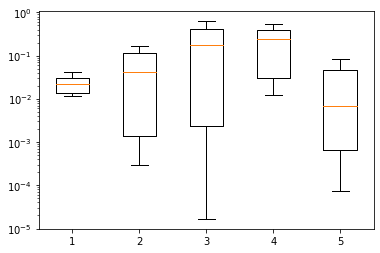

In [12]:
plt.boxplot(rse);
plt.yscale('log')

In [13]:
np.sum(switched)/Nrep

0.7